In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import time
import matplotlib.pyplot as plt
import json, codecs
import numpy as np
from skimage import color
from keras.optimizers import Adam
from keras.datasets import cifar10
import matplotlib.image as mpimg

from fastmri_recon.helpers.utils import keras_ssim, keras_psnr
from fastmri_recon.data.test_generators import DataGenerator
from fastmri_recon.models.unet import unet
from fastmri_recon.helpers.evaluate import psnr, ssim, mse, nmse

from fastmri_recon.models.discriminator import discriminator_model, generator_containing_discriminator_multiple_outputs
from fastmri_recon.helpers.adversarial_training import compile_models


Using TensorFlow backend.


In [2]:
# parameter initialization

AF=2
run_params = {
    'n_layers': 4, 
    'pool': 'max', 
    "layers_n_channels": [16, 32, 64, 128], 
    'layers_n_non_lins': 2,
}

In [3]:
def load_data(path):
    path_train = path + "train/"
    path_test = path + "test/"
    train = os.listdir(path_train)
    train_data = []
    for s in train:
        for image in os.listdir(path_train+s):       
            train_data.append(mpimg.imread(path_train+s+'/'+image))

    test = os.listdir(path_test)
    test_data = []
    for s in test:
        for image in os.listdir(path_test+s):          
            test_data.append(mpimg.imread(path_test+s+'/'+image))

    x_train = color.rgb2gray(np.array(train_data))
    x_test = color.rgb2gray( np.array(test_data))

    return x_train, x_test

In [4]:
#load data

path=""

if path != "":
    x_train, x_test = load_data(path)
else:
    (x_train, _), (x_test, _) = cifar10.load_data()
    x_train = color.rgb2gray(x_train)
    x_test = color.rgb2gray(x_test)

im_size = x_train[0].shape[0]
print(im_size)
val_gen = DataGenerator(AF, x_test).flow_z_filled_images()
train_gen = DataGenerator(AF, x_train).flow_z_filled_images()

32


In [5]:
def generator_model():
    model = unet(input_size=(im_size, im_size, 1), **run_params, compile=False)
    model.name = 'Reconstructor'
    return model

In [6]:
# model definitions
g = generator_model()
d = discriminator_model(im_size)
d_on_g = generator_containing_discriminator_multiple_outputs(g, d, im_size=im_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [7]:
# model compiling
perceptual_loss = 'mae'

discriminator_lr = 1e-4
d_on_reconstructor_lr = 1e-4

compile_models(
    d, 
    g, 
    d_on_g, 
    d_lr=discriminator_lr, 
    d_on_g_lr=d_on_reconstructor_lr, 
    perceptual_loss=perceptual_loss, 
    perceptual_weight=1.0,
)

In [9]:
# load weights
path = '../checkpoints/gen_af2_1576070105-30.hdf5'
g.load_weights(path)

In [10]:
# evaluate generator
ev = g.evaluate_generator(val_gen, steps=200, callbacks=None, verbose=1)
print('test loss, psnr,ssim:', ev)



  1/200 [..............................] - ETA: 41s

/Users/WorkAccount/fastmri-reproducible-benchmark/fastmri_recon/data/test_generators.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  kspaces[i, ..., 0] = kspace
/Users/WorkAccount/fastmri-reproducible-benchmark/fastmri_recon/helpers/reconstruction.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  x_final[i] = fourier_op.adj_op(kspace)


200/200 [==============================] - 1s 7ms/step
test loss, psnr,ssim: [0.09779807925224304, 15.19767951965332, 0.4293854534626007, 0.024660658091306686]


In [11]:
def show_images(images, cols = 1, title=None, titles = None, scale = 1, save=''):
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(facecolor="white")
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)) +1 , n + 1)
        plt.imshow(image, )
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images * scale)
    if save != '':
        plt.savefig(save)
    plt.show()

In [12]:
def show_prediction(g, im_true, im_alias):
    im_pred =  g.predict(im_alias)
    im_true = np.squeeze(im_true)
    im_alias = np.squeeze(im_alias)
    im_pred = np.squeeze(im_pred)
    show_images([im_true, im_alias, im_pred], titles=["true", "aliased", "predicted"])
    print("PSNR aliased image: ", psnr(im_true, im_alias), "\nPSNR predicted image:", psnr(im_true, im_pred))
    print("\nMSE aliased image: ", mse(im_true, im_alias), "\nMSE predicted image:", mse(im_true, im_pred))
    print("\nNMSE aliased image: ", nmse(im_true, im_alias), "\nNMSE predicted image:", nmse(im_true, im_pred))
    

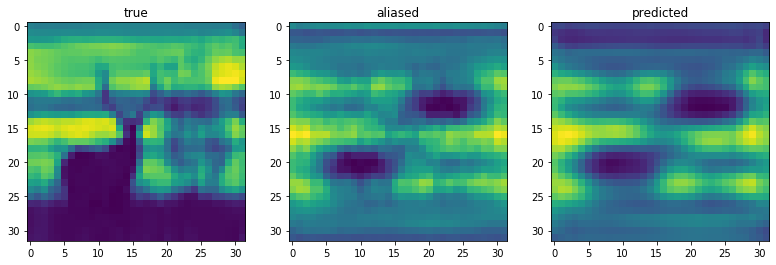

PSNR aliased image:  5.047947842533134 
PSNR predicted image: 10.806999027398458

MSE aliased image:  0.23779987546930592 
MSE predicted image: 0.06314028013022023

NMSE aliased image:  0.9938461993970181 
NMSE predicted image: 0.2638846101682763


/Users/WorkAccount/fastmri-reproducible-benchmark/fastmri_recon/helpers/evaluate.py:25: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  return compare_psnr(gt, pred, data_range=gt.max() - gt.min())


In [13]:
im = next(val_gen)
show_prediction(g, im[1], im[0])